# Eldery Monitoring Project

## Step 1: Preprocessing and Merging

In [1]:
import pandas as pd

# Load the gas/temperature/humidity data
gas_df = pd.read_csv("database_gas.csv")

# Load the position (room) data
pos_df = pd.read_csv("database_pos.csv")

# Ensure datetime columns are parsed correctly
gas_df['datetime'] = pd.to_datetime(gas_df['timestamp'], utc=True)
pos_df['datetime'] = pd.to_datetime(pos_df['datetime'], utc=True)

# Convert gas_df from UTC+01:00 to UTC
gas_df['datetime'] = gas_df['datetime'].dt.tz_convert('UTC')

# Sort both DataFrames by datetime
gas_df = gas_df.sort_values('datetime')
pos_df = pos_df.sort_values('datetime')

# Do a nearest timestamp merge
# **might be a limitation**
merged_df = pd.merge_asof(
    gas_df,
    pos_df,
    on='datetime',
    direction='nearest'  # or 'nearest' if you prefer that
)

In [2]:
merged_df.head()
merged_df.info()
merged_df.to_csv('merged_data.csv', index=False)
print("saved")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416153 entries, 0 to 416152
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   timestamp      416153 non-null  object             
 1   temperature    416153 non-null  float64            
 2   humidity       416153 non-null  float64            
 3   CO2CosIRValue  416153 non-null  float64            
 4   CO2MG811Value  416153 non-null  float64            
 5   MOX1           416153 non-null  float64            
 6   MOX2           416153 non-null  float64            
 7   MOX3           416153 non-null  float64            
 8   MOX4           416153 non-null  float64            
 9   COValue        416153 non-null  float64            
 10  datetime       416153 non-null  datetime64[ns, UTC]
 11  Living room    119043 non-null  float64            
 12  Bedroom        112610 non-null  float64            
 13  Bathroom       20691 non-null

## Step 2: Exploring Data

In [3]:
# Determine the active room (assuming only one room is active per row)
room_cols = ['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']

# Fill NaNs with 0 for room columns so idxmax doesn't raise issues
merged_df['active_room'] = merged_df[room_cols].fillna(0).idxmax(axis=1)

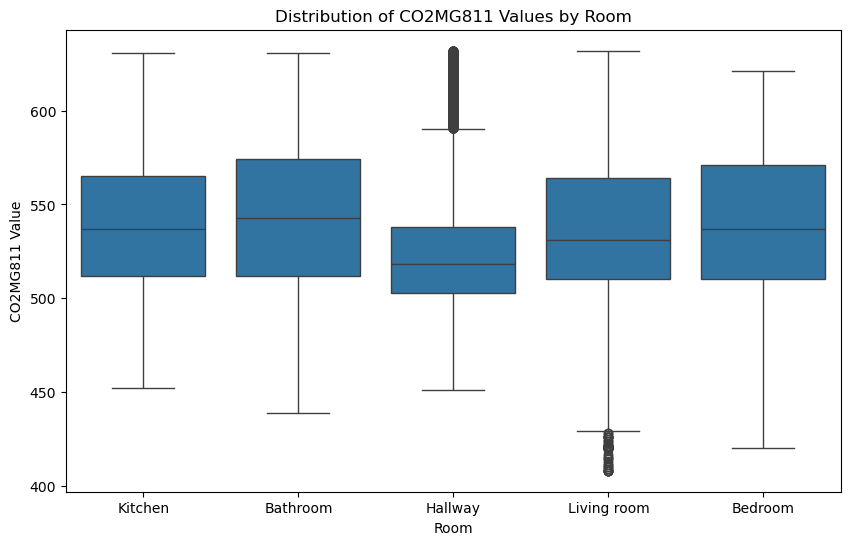

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x='active_room', y='CO2MG811Value', data=merged_df)
plt.title('Distribution of CO2MG811 Values by Room')
plt.ylabel('CO2MG811 Value')
plt.xlabel('Room')
plt.show()


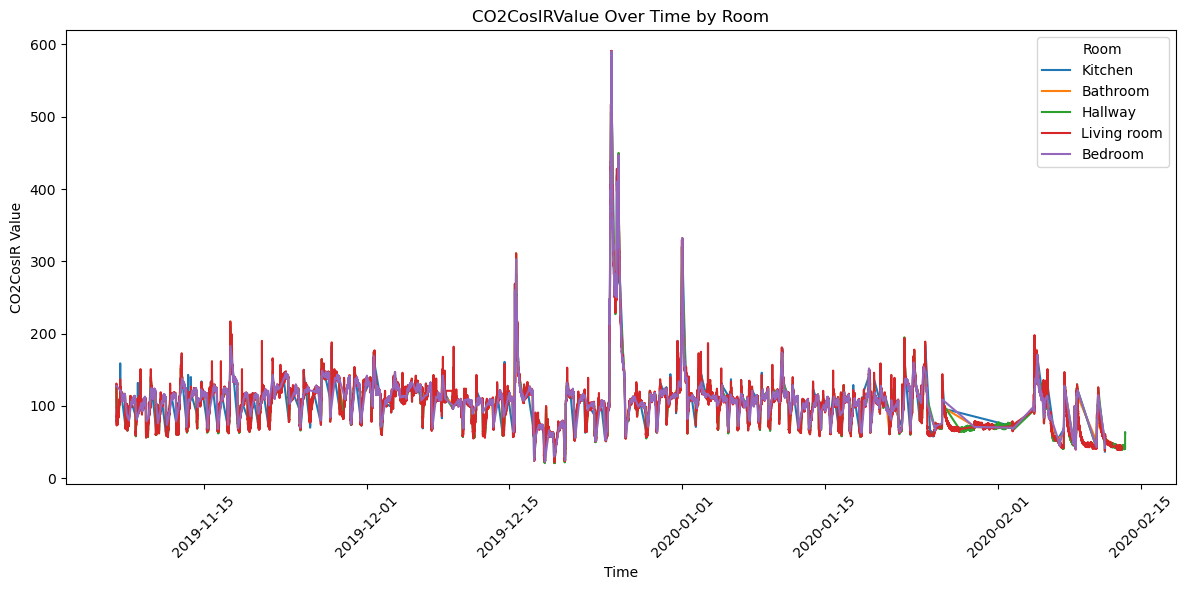

In [5]:
plt.figure(figsize=(12,6))
sns.lineplot(x='datetime', y='CO2CosIRValue', hue='active_room', data=merged_df)
plt.title('CO2CosIRValue Over Time by Room')
plt.xlabel('Time')
plt.ylabel('CO2CosIR Value')
plt.xticks(rotation=45)
plt.legend(title='Room')
plt.tight_layout()
plt.show()

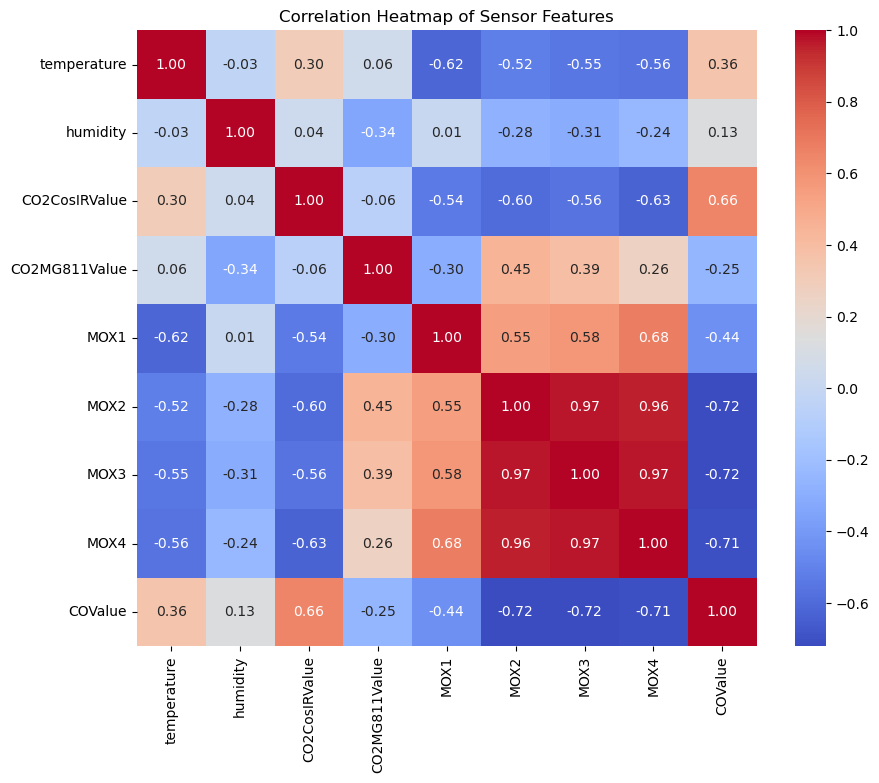

In [6]:
plt.figure(figsize=(10, 8))
sensor_cols = ['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']
corr = merged_df[sensor_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Sensor Features')
plt.show()

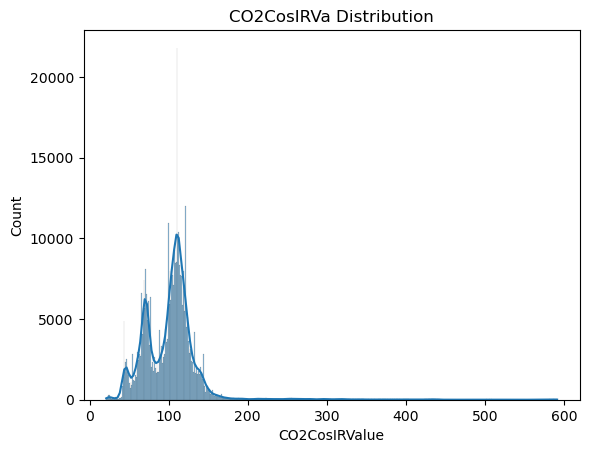

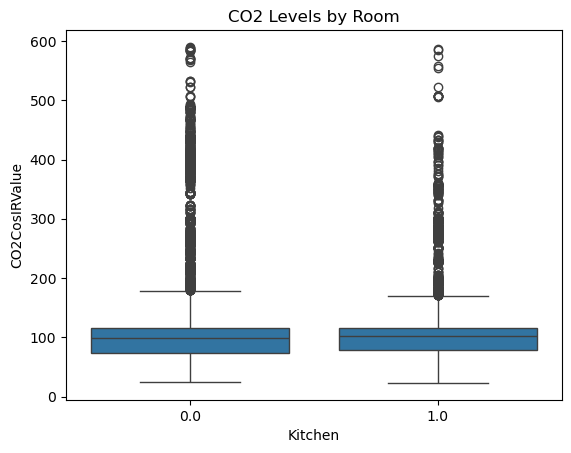

In [7]:
# Plot distributions
sns.histplot(data=merged_df, x='CO2CosIRValue', kde=True)
plt.title('CO2CosIRVa Distribution')
plt.show()

# Boxplot by room
sns.boxplot(data=merged_df, x='Kitchen', y='CO2CosIRValue')
plt.title('CO2 Levels by Room')
plt.show()

## Step 3: Baseline Model - Random Forest Classifier

### 3.1 Train/Test Split

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define feature columns (CO2 + other gas-related data)
feature_cols = ['CO2CosIRValue', 'CO2MG811Value', 'temperature', 'humidity',
                'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']

# Target is the active room
X = merged_df[feature_cols]
y = merged_df['active_room']  # should be one of the room names as a string

# Drop any rows with NaNs (or handle appropriately)
X = X.dropna()
y = y.loc[X.index]  # Keep alignedd\

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 3.2 Results

In [11]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Bathroom       0.70      0.60      0.65      1603
     Bedroom       0.96      0.96      0.96     11263
     Hallway       0.94      0.91      0.92      9157
     Kitchen       0.95      0.91      0.93      4760
 Living room       0.96      0.98      0.97     56448

    accuracy                           0.96     83231
   macro avg       0.90      0.87      0.89     83231
weighted avg       0.96      0.96      0.96     83231



## Step 4: Model Tuning
### 4.1 LightGBM

In [12]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [13]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels if not done already
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgbm.predict(X_test)

# Evaluation
print("LightGBM Results:\n")
print(classification_report(y_test, y_pred_lgbm, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 332922, number of used features: 9
[LightGBM] [Info] Start training from score -3.917360
[LightGBM] [Info] Start training from score -1.999869
[LightGBM] [Info] Start training from score -2.201188
[LightGBM] [Info] Start training from score -2.818295
[LightGBM] [Info] Start training from score -0.393970
LightGBM Results:

              precision    recall  f1-score   support

    Bathroom       0.75      0.08      0.14      1603
     Bedroom       0.84      0.66      0.74     11263
     Hallway       0.95      0.70      0.81      9157
     Kitchen       0.94      0.30      0.45      4760
 Living room       0.83      0.97      0.89     56448

    accuracy                    

### 4.2 XGBoost

In [14]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels if not already done
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("XGBoost Results:\n")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

/opt/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:24] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:

              precision    recall  f1-score   support

    Bathroom       0.76      0.11      0.19      1603
     Bedroom       0.86      0.78      0.82     11263
     Hallway       0.95      0.76      0.85      9157
     Kitchen       0.94      0.43      0.59      4760
 Living room       0.86      0.97      0.91     56448

    accuracy                           0.87     83231
   macro avg       0.87      0.61      0.67     83231
weighted avg       0.88      0.87      0.86     83231



### 4.3 MLP Classifier

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 1. Prepare your data
# X: feature columns (e.g. CO2CosIRValue, CO2MG811Value, etc.)
# y: target labels (e.g. 'active_room')

X = merged_df[['CO2CosIRValue', 'CO2MG811Value']]  # add other relevant features too
y = merged_df['active_room']

# Encode target labels if they're strings
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Define and train the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, early_stopping=True, random_state=42)
mlp.fit(X_train_scaled, y_train)

# 5. Predict and evaluate
y_pred = mlp.predict(X_test_scaled)

# 6. Classification report
print("MLP Classifier Results:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


🎯 MLP Classifier Results:

              precision    recall  f1-score   support

    Bathroom       0.00      0.00      0.00      1645
     Bedroom       0.00      0.00      0.00     11265
     Hallway       0.66      0.31      0.42      9200
     Kitchen       0.00      0.00      0.00      4928
 Living room       0.69      0.97      0.81     56193

    accuracy                           0.69     83231
   macro avg       0.27      0.26      0.25     83231
weighted avg       0.54      0.69      0.59     83231



/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Step 8: Model Interpretation

In [ ]:
import shap
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=features)